In [ ]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_predictions(X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor, y_pred: torch.Tensor, model: nn.Module) -> None:
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.scatter(X_test.cpu().numpy(), y_test.cpu().numpy(), color='darkturquoise', edgecolors='black', label='Test data')
    ax.scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), color='darksalmon', edgecolors='black', label='Train data')
    ax.scatter(X_test.cpu().numpy(), y_pred.detach().cpu().numpy(), color='yellowgreen', edgecolors='black', label='Predictions')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title('Predictions', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
    ax.legend(prop={'size': 10, 'style': 'italic'})
    plt.show()

def plot_curves(epoch_count: np.ndarray, train_loss_values: np.ndarray, test_loss_values: np.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(epoch_count, train_loss_values, label='Train loss', color='darkturquoise')
    ax.plot(epoch_count, test_loss_values, label='Test loss', color='darksalmon')
    ax.set_title('Loss over epochs', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

- *Cambiamos un poco el código de nuestro modelo. Ahora utilizamos la clase `nn.Linear`, la cual nos permite implementar una transformación lineal sobre los datos de entrada:*
$$
y = W\cdot X + b
$$
- *Tiene tres argumentos:*
    - *`in_features` (`int`). Es la cantidad de valores de entrada que recibe. Se puede pensar como la cantidad de features.*
    - *`out_features` (`int`). Es la cantidad de valores de salida que tiene.*
    - *`bias` (`bool`). Por defecto está definido como `True`. Si se define como `False`, entonces el modelo no aprende ese parámetro.*
- *Esta clase se encarga de crear los tensores (con la clase `nn.Parameter`) para los parámetros del modelo, por lo que no tenemos que definirlos manualmente como antes.*
- *Vamos a observar ligeras diferencias entre este modelo y el anterior. Esto se debe a: la manera en la que se inicializan los parámetros (`nn.Linear` utiliza el método de Kaiming/He mientras que el modelo anterior utilizaba `torch.randn`), la manera en que se ordenan los parámetros cuando usamos `nn.Linear`, y como fueron computados los gradientes.*

In [3]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        #self.weight = nn.Parameter(torch.randn(1, dtype=torch.float32))
        #self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32))
        self.linear = nn.Linear(1, 1, dtype=torch.float32) # This is a linear layer with just one input (X) and one output (y)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        Args:
            X (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor after applying linear transformation.
        """
        return self.linear(X)
    
# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the model
model_0 = LinearRegressionModel()

# Print the model's parameters
print("Model parameters before training:")
model_0.state_dict()

Model parameters before training:


OrderedDict([('linear.weight', tensor([[0.7645]])),
             ('linear.bias', tensor([0.8300]))])

- *Cuando particionamos los datos de entrenamiento y evaluación usando índices, esto nos devuelve un tensor uni-dimensional de tamaño `(n_samples, )`. `nn.Linear` espera recibir un tensor bi-dimensional de tamaño `(batch_size, n_features)`.*
- *Agregamos una dimensión extra (`dim=1`) utilizando el método `unsqueeze()`.*

In [4]:
train_data = torch.load('temp/data/train_data.pt')
test_data = torch.load('temp/data/test_data.pt')

# When we split the data using [:, 0], this returns a 1D tensor of shape (n_samples, )
# The nn.Linear layer expects a 2D tensor of shape (batch_size, n_features), so we need to add an extra dimension.
X_train = train_data[:, 0].unsqueeze(1)
y_train = train_data[:, 1].unsqueeze(1)
X_test = test_data[:, 0].unsqueeze(1)
y_test = test_data[:, 1].unsqueeze(1)

- *Definimos la función de pérdida y el optimizador que vamos a utilizar. Luego, entrenamos nuestro modelo con el loop que creamos anteriormente.*

In [5]:
loss_function = nn.L1Loss()
optimizer = optim.SGD(model_0.parameters(), lr=0.01, momentum=0.8)

In [6]:
# An epoch is one complete pass through the dataset
epochs = 100

# Creates a NumPy array to store the loss functions values
epoch_count = np.arange(epochs)
train_loss_values = np.zeros(epochs)
test_loss_values = np.zeros(epochs)

for epoch in np.arange(epochs):
    ##### Training Loop #####

    # Set the model to training mode
    model_0.train()

    # Foward pass
    # We don't have to call the `forward()` method explicitly, because it's called automatically when the model is called
    y_pred = model_0(X_train)

    # Calculate the loss
    train_loss = loss_function(y_pred, y_train)
    train_loss_values[epoch] = train_loss.item()

    # Zero the gradients
    # This is an important step, because by default, gradients are accumulated in PyTorch
    # If we don't zero the gradients, the gradients will be added to the previous gradients
    optimizer.zero_grad()

    # Backward pass
    # This calculates the gradients of the loss with respect to the model parameters
    train_loss.backward()

    # Update the model parameters
    optimizer.step()

    ### Validation Loop #####

    # Set the model to evaluation mode
    model_0.eval()

    # Turn on inference mode.
    with torch.inference_mode():
        # Forward pass
        y_test_pred = model_0(X_test)

        # Calculate the loss for the test set
        test_loss = loss_function(y_test_pred, y_test)
        test_loss_values[epoch] = test_loss.item()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Train loss: {train_loss.item()} | Test loss: {test_loss.item()}')

Epoch: 0 | Train loss: 0.5555006265640259 | Test loss: 0.5742346048355103
Epoch: 10 | Train loss: 0.18386763334274292 | Test loss: 0.09078267961740494
Epoch: 20 | Train loss: 0.02612186037003994 | Test loss: 0.043764594942331314
Epoch: 30 | Train loss: 0.015359227545559406 | Test loss: 0.029232025146484375
Epoch: 40 | Train loss: 0.006316865794360638 | Test loss: 0.0003258049546275288
Epoch: 50 | Train loss: 0.004055710509419441 | Test loss: 0.004812613129615784
Epoch: 60 | Train loss: 0.015268921852111816 | Test loss: 0.006429112050682306
Epoch: 70 | Train loss: 0.005372021347284317 | Test loss: 0.008485508151352406
Epoch: 80 | Train loss: 0.005231801886111498 | Test loss: 0.0005595237016677856
Epoch: 90 | Train loss: 0.004946461413055658 | Test loss: 0.0051205395720899105


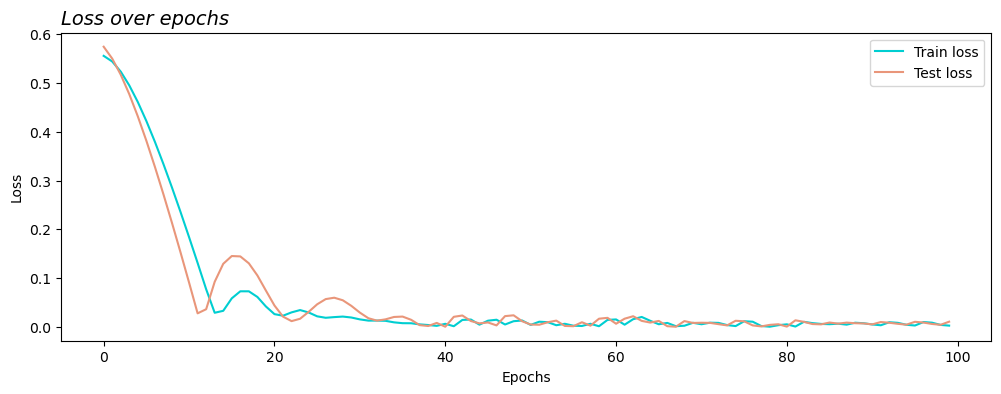

In [7]:
plot_curves(epoch_count, train_loss_values, test_loss_values)

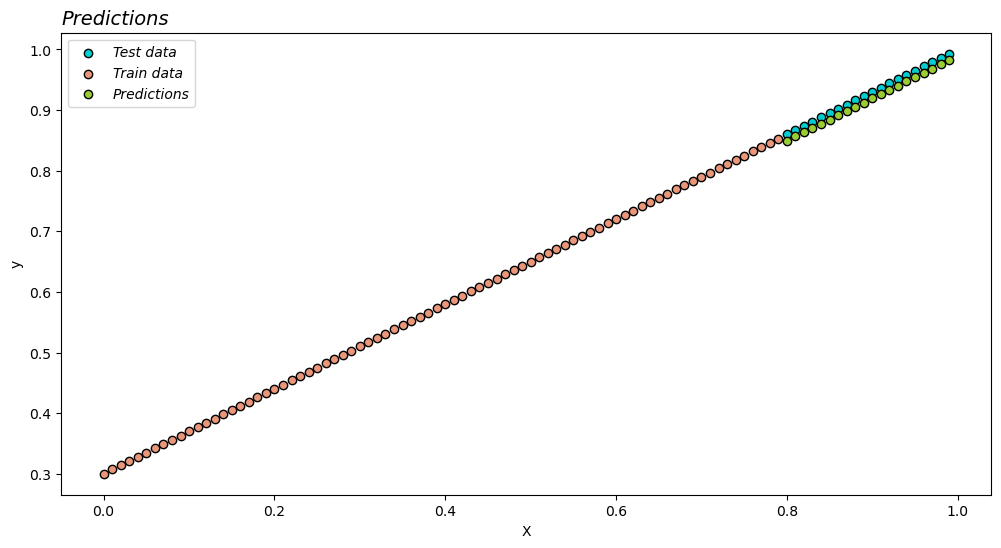

In [8]:
plot_predictions(X_train, y_train, X_test, y_test, y_test_pred, model_0)

### Guardar un modelo

- *Una vez que entrenamos y evaluamos nuestro modelo, lo guardamos. Con guardar los pesos es suficiente (y también es lo recomendable).*
- *Podemos acceder a los parámetros (entrenables) de nuestro modelo a través de `torch.nn.Module.state_dict()`. Este es un diccionario que contiene el estado actual de los parámetros del modelo.*
- *Para guardar los parámetros del modelo utilizamos la función `torch.save()`, la cual implementa la librería `pickle` que nos permite guardar/cargar objetos de Python. Le tenemos que pasar el objeto que queremos guardar, en nuestro caso `torch.nn.Module.state_dict()`, y el directorio en donde lo queremos guardar.*
    - *La convención es utilizar `.pt` o `.pth` como la extensión del archivo.*

- *Para más información sobre como guardar un modelo y las distintas opciones que hay, consultar este [artículo](https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended).*

In [9]:
# Save the model
print('Saving the model...')
torch.save(model_0.state_dict(), f'models/model_0.pth')
print('Model saved successfully')

Saving the model...
Model saved successfully


- *Podemos cargar un modelo utilizando la función `torch.nn.Module.load_state_dict()`. Notar que primero tenemos que crear una nueva instancia de nuestro modelo, usualmente con los parámetros iniciados aleatoriamente, y luego reemplazar los parámetros por los que guardamos.*
- *También es importante entender que la función `torch.nn.Module.load_state_dict()` acepta un diccionario, y no la ruta en donde está guardado. Esto quiere decir que primero tenemos que cargar el objeto, usando la función `torch.load()`, y luego actualizar los pesos del modelo.*

In [10]:
# Create a new model instance
model = LinearRegressionModel()
print("Model parameters:")
print(model.state_dict())

# Load the model's parameters. We only load the parameters, not the entire model
parameters = torch.load(f'models/model_0.pth', weights_only=True)

# Update the model's parameters with the loaded parameters
model.load_state_dict(parameters)
print("Trained model parameters:")
print(model.state_dict())

Model parameters:
OrderedDict([('linear.weight', tensor([[-0.2343]])), ('linear.bias', tensor([0.9186]))])
Trained model parameters:
OrderedDict([('linear.weight', tensor([[0.6990]])), ('linear.bias', tensor([0.2903]))])


Are the predictions the same as before? True


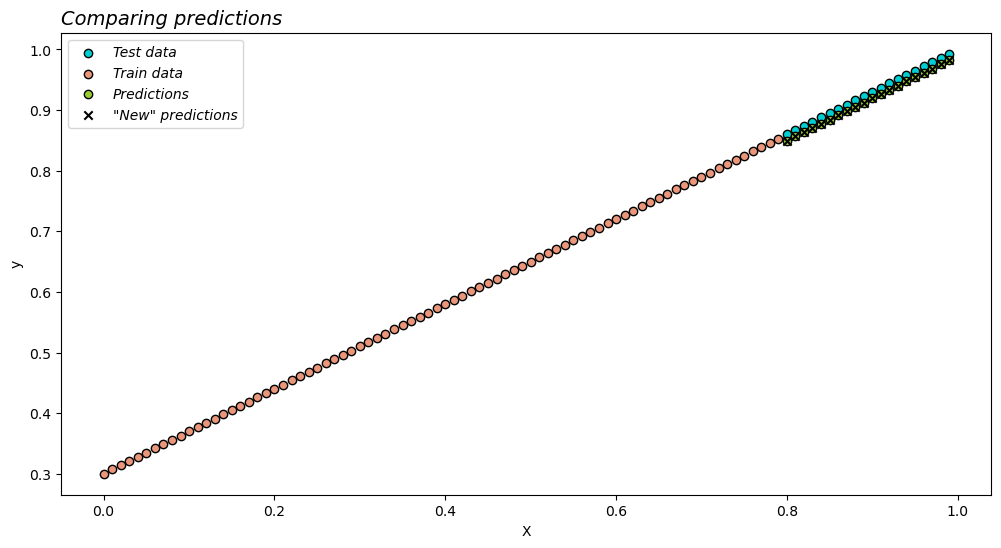

In [11]:
model.eval()
with torch.inference_mode():
    predictions = model(X_test)

print(f'Are the predictions the same as before? {torch.equal(predictions, y_test_pred)}')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(X_test.cpu().numpy(), y_test.cpu().numpy(), color='darkturquoise', edgecolors='black', label='Test data')
ax.scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), color='darksalmon', edgecolors='black', label='Train data')
ax.scatter(X_test.cpu().numpy(), y_test_pred.detach().cpu().numpy(), color='yellowgreen', edgecolors='black', label='Predictions')
ax.scatter(X_test.cpu().numpy(), predictions.detach().cpu().numpy(), color='black', marker='x', label='"New" predictions')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Comparing predictions', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
ax.legend(prop={'size': 10, 'style': 'italic'})
plt.show()